<div style="text-align: center;">

# MACHINE LEARNING PROJECT
## Deliverable #2

**<h3 align="center">CARS 4 YOU</h3>**

<span style="font-size: 24px;">Master in Data Science and Advanced Analytics</span>  
<span style="font-size: 24px;">NOVA Information Management School</span>  
<span style="font-size: 20px;"><i>Group 34</i></span>  
<span style="font-size: 20px;">Fall/Spring Semester 2025-2026</span>

</div>


## I. Group Member Contribution

| Student Name | Student ID | Contribution (%) | Specific Tasks & Responsibilities |
| :--- | :--- | :---: | :--- |
| **Carolina Luz** | 20250409 | 25% | Abstract, Data Exploration and Cleaning|
| **Margarida Quintino** | 20250411 | 25% | Regression Benchmarking, Open-Ended and website|
| **Pedro Castro** | 20250467 | 25% | Model Optimization, Regression Benchmarking and Deployment|
| **Pedro Carrasqueira** | 20250488 | 25% | Open-Ended and Regression Benchmarking |

**Total Contribution:** 100%

**Note:** All members contributed equaly for this project. Even though each person put more effort in a specific part of this project, all of us contributed to all parts.

## II. Abstract
Accurate pricing of used vehicles is a major challenge for online resale platforms, where manual inspections are costly and unscalable. Focusing on robustness and interpretability, this project offers a complete end-to-end machine learning system for automated vehicle valuation.

To ensure reproducibility and prevent data leakage, the architecture integrates data cleaning, feature engineering, and automated feature selection into a single Scikit-Learn pipeline. Given the highly skewed nature of car prices (driven by rare luxury vehicles), a log-transformation was applied to the target variable. While benchmarks between StandardScaler and RobustScaler yielded comparable metrics, RobustScaler was strategically selected to mitigate the influence of extreme market outliers.

Feature complexity was analyzed using Recursive Feature Elimination (RFE) and a comparative study of embedded methods (Lasso vs. Random Forest). Results indicated that performance stabilizes at seven features, representing the optimal trade-off between predictive accuracy and model parsimony.

The final Random Forest model, tuned via RandomizedSearchCV, achieved a Mean Absolute Percentage Error (MAPE) of 6.38% and a Mean Absolute Error (MAE) of £1,069, explaining approximately 97% of the variance ($R^2$=0.9678) in unseen data. Analysis confirmed that Model, Age, and Mileage are the primary value drivers, while Fuel Type and Tax were algorithmically discarded as noise. The substantial performance gap between Tree-based models (RMSE ~0.119) and Linear baselines (RMSE ~0.182) scientifically confirms the non-linear structure of vehicle depreciation. The optimized pipeline was deployed as "My Car Value," a web-based inference engine converting these technical findings into real-time commercial value.

## III. Identifying Business Needs

### Overview and Main Goals
**Cars 4 You** is an online car resale company that operates a platform where users provide details about their vehicles to sell them. Currently, the business model relies on a chain of mechanics to inspect and evaluate every car before purchase, which allows the company to resell them for a profit.

However, the company's growth has created a bottleneck: the reliance on manual inspections has led to increasing waiting lists, which is driving potential customers to competitors.

**The primary goal of this project** is to expedite the evaluation process by developing a predictive machine learning model. This model effectively estimates the price of a car based on the user's input attributes (e.g., brand, mileage, year) without requiring a physical inspection by a mechanic.

To achieve this, the project is structured around three key objectives:
1.  **Regression Benchmarking:** Develop and compare multiple regression models using a dataset from 2020 to create a proof-of-concept and identify the most generalizable approach.
2.  **Model Optimization:** Improve the performance of the best candidate model(s) through techniques such as hyperparameter tuning and feature selection.
3.  **Deployment:** Implement a final pipeline to generate reliable price predictions for new data (the test set).

### Model Assessment Strategy
To ensure the final model is robust and generalizes well to unseen data, we have adopted the following assessment strategy:

* **Data Splitting:** The available training data (cars from 2020) will be used to build and validate the models. We will verify performance on the unseen test set via the Kaggle competition.
* **Validation Method:** We will employ **[K-Fold Cross-Validation]** to assess model performance. This allows us to compare different candidate models consistently and identify the one with the best generalization capability[cite: 21, 57].
* **Evaluation Metrics:** As this is a regression problem, we will primarily evaluate models using **[RMSE (Root Mean Squared Error), $R^2$ and MAE]** to measure prediction accuracy.

## 1. Project Setup & Definition

### 1.1. Libraries & Environment Configuration

In this section, we establish the technical foundation for the pipeline. We import the standard Data Science stack (Pandas, NumPy) and the specific Scikit-Learn modules required for our workflow.

In [1]:
# Standard Python Libraries
from difflib import get_close_matches
import warnings

# Standard Data Manipulation & Mathematics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Scikit-Learn: Pipeline & Preprocessing Architecture
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector 
from sklearn.base import BaseEstimator, TransformerMixin

# Imputation Modules
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, IterativeImputer 

# Preprocessing
from sklearn.preprocessing import RobustScaler, TargetEncoder

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# Scikit-Learn: Model Selection, Evaluation & Inspection
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    mean_absolute_percentage_error
)

# Scikit-Learn: Algorithms (Regressors)
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet

# Statistical Distributions
from scipy.stats import randint, uniform

### 1.2. Global configuration

Here, we establish the global runtime settings to ensure our notebook remains both readable and strictly reproducible. We begin by defining a global random seed (RSEED = 42), which is passed to every stochastic component in the pipeline guaranteeing that our results are identical every time the code is executed. Simultaneously, we adjust Pandas display options to prevent column wrapping so we can inspect wide dataframes without visual truncation, and we silence non-critical warnings to keep our training logs clean and focused.

In [2]:
#Suppress warnings to maintain a clean execution log during iterative training
warnings.filterwarnings('ignore')

# Configure Pandas display options for easier dataframe inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Define Global Random Seed for Reproducibility
# This ensures that all random operations (splits, initializations) are constant.
RSEED = 42
np.random.seed(RSEED)

### 1.3. Data Loading & Target Transformation

In this step, we load the raw datasets and perform the most critical pre-modeling adjustment: Log-Transformation of the Target Variable.

The target variable, `price`is right-skewed (as concluded in the EDA phase). There is a high number of cars priced around $10k-$20k, but the curve extends far to the right for luxury vehicles ($100k+).

Standard Regression models (especially Linear ones) struggle with this asymmetry. They tend to over-predict cheap cars and under-predict expensive ones because the variance is not constant (heteroscedasticity).

Applying `np.log1p` compresses the range. A price difference of $5k means a lot for a cheap car but very little for a Ferrari. Log-space converts these "multiplicative" differences into "additive" distances, stabilizing the variance and making the error distribution Normal (Gaussian).

In [3]:
# Load the training and testing datasets from the working directory
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Isolate the Target Variable ('price') and Features (X)
# We use the suffix '_full' to indicate this is the complete training set
# prior to any cross-validation splitting.
X_train_full = train_df.drop(columns=['price'])
y_train_full = train_df['price']

#Apply Log-Transformation to Target
# Predicting log(price) stabilizes variance and improves linear model performance.
y_train_log = np.log1p(y_train_full)

## 2. Data Processing Architecture

### 2.1. Data Cleaning *Engine*

In this section, we encapsulate the entire data cleaning logic into a reusable DataCleaner class. This architecture guarantees that the exact same transformations applied to our training data are also applied to the test data, eliminating the risk of processing inconsistencies.

Our cleaning strategy relies on a mix of Algorithmic Correction and Domain Rules:

* **Leakage Prevention:** We immediately move carID to the index. This hides it from the machine learning model (preventing it from memorizing IDs) while preserving it for the final submission file.

* **Fuzzy Matching:** To address data entry errors, we use sequence similarity. This automatically maps slightly misspelled brands, fuels, and transmissions (e.g., "Mercdes") to their correct "Golden Source" labels.

* **Logical Checks:** We enforce logical constraints to ensure data integrity. Records containing logically impossible values (such as negative mileage or production years beyond the 2020) are flagged as data errors. These entries are then converted to NaN, allowing our downstream imputation pipeline to resolve them systematically.

In [4]:
class DataCleaner:
    """
    Applies robust, algorithmic cleaning rules to the raw dataset.
    
    PURPOSE:
    To standardize categorical labels, sanitize numeric errors, and properly 
    handle the 'carID' identifier to prevent feature leakage.
    """
    
    def __init__(self):
        """
        Initializes the cleaning agent with 'Golden Source' definitions.
        """
        # 1. GOLDEN SOURCE DEFINITIONS
        self.valid_brands = [
            'audi', 'bmw', 'ford', 'hyundai', 'mercedes', 'opel', 
            'skoda', 'toyota', 'volkswagen'
        ]
        
        self.valid_transmissions = ['manual', 'semi-auto', 'automatic']
        self.valid_fuels = ['petrol', 'diesel', 'hybrid', 'other']
        
        # 2. EXCEPTION: MANUAL MAPPING (MODELS)
        self.model_map = {
             'tigua': 'tiguan', 't-ro': 't-roc', 'tiguan allspac': 'tiguan allspace',
             'astr': 'astra', 'fiest': 'fiesta', 'insigni': 'insignia',
             'octavi': 'octavia', 'monde': 'mondeo', 'passa': 'passat',
             'edg': 'edge', 'mokk': 'mokka', 'arteo': 'arteon',
             'aur': 'auris', 'fabi': 'fabia', 'ayg': 'aygo',
             'gol': 'golf', 'coroll': 'corolla', 'zafir': 'zafira',
             'c-ma': 'c-max', 'grand c-ma': 'grand c-max', 'b-ma': 'b-max',
             'yeti outdoo': 'yeti outdoor', 'grand tourneo connec': 'grand tourneo connect'
        }

        # 3. EXCEPTION: MANUAL MAPPING (BRANDS)
        # Added to catch abbreviations that fuzzy matching misses
        self.brand_map = {
            'vw': 'volkswagen',
            'v w': 'volkswagen', 
            'merc': 'mercedes'
        }

    def _fuzzy_correct(self, value, valid_list, cutoff=0.75):
        """
        Internal helper function to apply Algorithmic Correction using Sequence Similarity.
        """
        if pd.isna(value): 
            return value
        if value in valid_list:
            return value
        
        matches = get_close_matches(value, valid_list, n=1, cutoff=cutoff)
        if matches:
            return matches[0]
            
        return 'unknown' 

    def transform(self, df):
        """
        Applies the cleaning logic to the dataframe.
        """
        df = df.copy() 
        
        # 1. INDEX HANDLING
        # We move 'carID' to the Index. This removes it from the 'features' list (hiding it from the model) 
        # while preserving it for the final submission file.
        if 'carID' in df.columns:
            df = df.set_index('carID')
        
        # 2. String Standardization
        str_cols = ['Brand', 'transmission', 'fuelType', 'model']
        for col in str_cols:
            if col in df.columns:
                df[col] = df[col].str.lower().str.strip()

        # 3a. Manual Correction (Brand) - APPLIED BEFORE FUZZY
        if 'Brand' in df.columns:
             df['Brand'] = df['Brand'].replace(self.brand_map)

        # 3b. Algorithmic Correction (Fuzzy Matching)
        if 'Brand' in df.columns:
            df['Brand'] = df['Brand'].apply(lambda x: self._fuzzy_correct(x, self.valid_brands, cutoff=0.7))
            
        if 'transmission' in df.columns:
            df['transmission'] = df['transmission'].apply(lambda x: self._fuzzy_correct(x, self.valid_transmissions, cutoff=0.8))
            
        if 'fuelType' in df.columns:
            df['fuelType'] = df['fuelType'].apply(lambda x: self._fuzzy_correct(x, self.valid_fuels, cutoff=0.8))

        # 4. Manual Correction (Model)
        if 'model' in df.columns:
            df['model'] = df['model'].replace(self.model_map)

        # 5. Numeric Sanity Checks
        cols_to_check = ['mileage', 'tax', 'mpg', 'engineSize', 'previousOwners']
        for col in cols_to_check:
            if col in df.columns:
                # Mask negative values as NaN
                df[col] = df[col].mask(df[col] < 0, np.nan)

        # 6. Temporal Logic
        if 'year' in df.columns:
            # Coerce to numeric, round to nearest integer
            df['year'] = pd.to_numeric(df['year'], errors='coerce').round()
            # Set years in the future (relative to dataset creation) to NaN
            df.loc[df['year'] > 2020, 'year'] = np.nan
            # Cast to nullable integer type
            df['year'] = df['year'].astype('Int64')

        # 7. Discrete Logic
        if 'previousOwners' in df.columns:
            # If owners is a decimal (e.g. 1.5 owners), set to NaN
            df.loc[df['previousOwners'] % 1 != 0, 'previousOwners'] = np.nan
            df['previousOwners'] = df['previousOwners'].astype('float')
            
        return df

# Execution
# We initialize the class and process both datasets immediately.
# Note: X_train_clean and X_test_clean will now have 'carID' as their Index.
cleaner = DataCleaner()
X_train_clean = cleaner.transform(X_train_full)
X_test_clean = cleaner.transform(test_df)

### 2.2. Feature Engineering & Preprocessing Architecture

In this section, we optimize the dataset in two stages. First, we use domain knowledge to create meaningful features and remove noise. Second, we format the data mathematically so the algorithms can process it without bias.

##### **Step 1: Feature Engineering and Manual Selection (CarFeatureEngineer)**

Before the data touches any algorithm, we manually create stronger signals and cut out the noise.

**New features**

`age`: Because depreciation is driven by the age of a vehicle rather than the calendar year it was made, calculating age directly allows the model to capture the loss in value more accurately.

`mileage_per_year`: Total mileage alone can be misleading. A car driven 50,000 miles in just one year suffers significantly more wear and tear than a car accumulating that same distance over a decade. This feature helps the model distinguish between heavy, intensive use and gentle, long-term driving.

**Manual selection** 

Besides engineering new features that bring aditional value to the model, we remove the ones that have no predective value, for the follwing reasons:

* Redundancy: `year` and `age` give the same information, but in different formats. Keeping both confuses linear models by introducing multicollinearity.

* Noise Reduction: Our EDA showed that `paintQuality%` and `previousOwners` have zero correlation with price. Feeding random noise to a model increases the possibility of it finding false patterns, therefore reducing it's predictions accuracy.

* Zero Variance: The `hasDamage` column contains the same value (0) for every single row. If a feature never changes, it can’t help us predict price differences.

##### **Step 2: Imputation, Scaling and Encoding**

Once the feature set is engineered, we must prepare it for the mathematical models by routing our data through two specialized pipelines to ensure mathematical stability.

**1. Numeric Pipeline**

* **Imputation:** A simple Univariate Imputation (filling NaN with the mean, median, or mode) would be a "one size fits all" and simplistic approach. It would not capture the particular relations between features. Therefore we use MICE (Multivariate Imputation by Chained Equations) instead as it is context-aware: it treats missing data as a target variable to be predicted, using correlations from other columns to generate statistically plausible values. This ensures that the natural variance and structural integrity of the dataset are preserved.

* **Scaling:** Machine learning algorithms are sensitive to feature magnitude and often yield biased results when input scales vary significantly. To mitigate this, we normalize all numeric data to a common range. We utilize a Robust Scaler, which performs normalization based on the Interquartile Range (IQR) rather than the mean. Unlike standard scaling, this method is resilient to outliers, ensuring that extreme data points—such as a rare £150k supercar—do not distort the feature space for the majority of the dataset.

**2. Categorical Pipeline**

* **Target Encoding:** Variables like `Model` have high cardinality. Standard "One-Hot Encoding" would create hundreds of sparse, empty columns, which slows down training and confuses the model. Instead, we use Target Encoding. This replaces the text label with the average price of a model in our training set. This effectively converts a qualitative text label into a quantitative value signal that linear algorithms can easily interpret.

* **Scaling:** We immediately apply a Robust Scaler to these encoded values. Since Target Encoding produces values in the range of "Price," they must be scaled down to match the range of our numeric features (like age). This alignment ensures that our linear models treat categorical and numeric signals with equal weight.

In [5]:
# 1. Custom Domain Logic Transformer (Class-Based)
class CarFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Encapsulates domain-specific logic into a Scikit-Learn compatible transformer.
    
    PURPOSE:
    To generate predictive features ('age', 'usage_intensity') and remove 
    redundant or noisy features to streamline the model.
    """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Robust Type Casting
        for col in ['year', 'mileage', 'engineSize']:
            if col in X.columns:
                X[col] = X[col].astype(float)
            
        # Depreciation feature: Age
        if 'year' in X.columns:
            X['age'] = (2020 - X['year']).clip(lower=0)
            
        # Usage intensity feature: mileage_per_year
        if 'mileage' in X.columns and 'age' in X.columns:
            X['mileage_per_year'] = np.where(
                X['age'] > 0, 
                X['mileage'] / X['age'], 
                X['mileage']
            )
            X['mileage_per_year'] = X['mileage_per_year'].replace([np.inf, -np.inf], 0)
            
        # 4. MANUAL PRUNING
        # - Drop 'year': Perfectly collinear with 'age' (redundant).
        # - Drop 'hasDamage': Zero Variance feature (constant value provides no signal).
        # - Drop 'paintQuality%' & 'previousOwners': Proven to be non-predictive noise via permutation importance.
        
        # We use errors='ignore' so the pipeline is robust even if columns are missing.
        cols_to_drop = ['year', 'paintQuality%', 'previousOwners', 'hasDamage'] # <--- UPDATED LIST
        
        X = X.drop(columns=cols_to_drop, errors='ignore')
            
        return X

# Initialize the Custom Transformer
feat_engineer = CarFeatureEngineer()


# 2. Preprocessing Pipelines

# NUMERIC PIPELINE
# Strategy: Multivariate Imputation + Robust Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(max_iter=10, random_state=RSEED)),
    ('scaler', RobustScaler())
])

# CATEGORICAL PIPELINE
# Strategy: Constant Imputation -> Target Encoding -> Robust Scaling
categorical_transformer = Pipeline(steps=[
    # 1. Fill missing values with 'unknown'
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    
    # 2. Convert Text to Numbers (Average Log-Price)
    ('encoder', TargetEncoder(target_type='continuous', smooth='auto', random_state=RSEED)),
    
    # 3. Scale the Encoded Numbers
    # This ensures encoded values are centered/scaled like the numeric features.
    ('scaler', RobustScaler())
])

## 3. Model Development & Optimization

### 3.1. Master Pipeline Assembly

In this final configuration step, we assemble the individual processing units into a single machine learning pipeline. This structure ensures that raw data flows through a strictly defined sequence of transformations (from engineering to selection) before reaching the final predictive model.

**Phase 1: Dynamic Data Routing (ColumnTransformer)**

Rather than hardcoding specific column names (which breaks if the dataset changes), we utilize make_column_selector to route data dynamically based on its type.
The pipeline automatically scans the input data. If a column is numeric, it is directed to the Numeric Pipeline if it is textual, it is directed to the Categorical Pipeline.
This approach is robust in the sense that, if we engineer new features or drop old ones upstream, the pipeline adapts automatically without requiring manual code adjustments.

**Phase 2: Automated Feature Selection (SelectFromModel)**

To prevent our model from being overwhelmed by noise, we embed a strict filtering mechanism directly into the pipeline. This step acts as a quality control checkpoint:

* We use a lightweight Random Forest to calculate the importance of every feature in real-time.

* Guided by our earlier Recursive Feature Elimination (RFE) analysis (which showed that predictive accuracy plateaus after just 7 variables) we set a hard limit of max_features=7. This forces the pipeline to discard weaker, noisy signals and pass only the highest-fidelity features to the final estimator.

**Phase 3: Pipeline Composition**

We encapsulate the entire workflow into a single executable object: *Raw Data → Engineering → Preprocessing → Selection → Prediction*

This architecture guarantees data safety. All learnable parameters are calculated only on the training data during .fit(). When predicting on unseen test data, the pipeline strictly applies these frozen rules, ensuring the model never "peeks" at the test set.

In [6]:
# PHASE 1: DYNAMIC ROUTING & PREPROCESSING
# Purpose: Transform raw data (text, messy numbers) into clean, scaled matrices.
# We use 'make_column_selector' so this adapts automatically if we add/remove features.

preprocessor = ColumnTransformer(
    transformers=[
        # 1. Numeric Pipeline (e.g., mileage, tax, age, mileage_per_year)
        # Action: Impute missing values (MICE) -> Scale outliers (RobustScaler)
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        
        # 2. Categorical Pipeline (e.g., Brand, fuelType)
        # Action: Impute missing -> Convert text to "Value" (Target Encoder)
        ('cat', categorical_transformer, make_column_selector(dtype_include=object))
    ],
    # Safety Net: Drop any column that isn't explicitly numeric or object
    remainder='drop' 
)


# PHASE 2: THE "GATEKEEPER" (Feature Selection)
# Purpose: Strictly filter the features BEFORE they reach the final model.
# Insight: Our RFE Analysis (Section 2) proved that accuracy plateaus after 7 features.
# Logic: We use a "Lite" Random Forest to rank features and keep strictly the Top 7.

rf_selector = SelectFromModel(
    estimator=RandomForestRegressor(n_estimators=50, max_depth=10, random_state=RSEED),
    max_features=7,    # <--- THE CRITICAL RULE (Derived from RFE)
    threshold=-np.inf  # Force it to keep exactly 7, regardless of score value
)



# PHASE 3: MASTER PIPELINE ASSEMBLY
# Purpose: Chain the phases into a single executable object.
# Flow: Raw Data -> Engineering -> Preprocessing -> Selection -> Prediction

model_pipeline = Pipeline(steps=[
    # Step 1: Feature Engineering 
    # (Creates 'age', 'mileage_per_year', drops 'year'/'hasDamage')
    ('engineer', feat_engineer),
    
    # Step 2: Preprocessing 
    # (Scales numbers, Encodes 'Ford' to 9.2, 'BMW' to 9.8)
    ('preprocessor', preprocessor),
    
    # Step 3: Feature Selection (LOCKED)
    # (The Gatekeeper: Throws away the bottom ~3 features)
    ('selector', rf_selector),
    
    # Step 4: Final Prediction
    # (Placeholder: Will be swapped with Lasso, Ridge, RF, or Boosting during Search)
    ('regressor', RandomForestRegressor(random_state=RSEED)) 
])

### 3.2. Definition of Hyperparameter Search Space

With our Feature Selection strategy proven (Random Forest Selection with max_features=7), we now pivot to finding the optimal Regressor.

To scientifically determine the best algorithm, we conduct a controlled experiment: we define 6 different modeling pipelines. Crucially, every candidate is forced to use the exact same feature selector (rf_selector). This ensures that any difference in performance is due to the algorithm's predictive power, not because one model saw different data than another.

##### **The Candidates:**

Our selection strategy balances Interpretability vs. Complexity and Bias vs. Variance, ensuring a comprehensive evaluation of the problem space.

* **Lasso Regression:** 
Lasso performs embedded feature selection by shrinking less useful coefficients to zero which helps manage noise from target encoding and provides a simple linear baseline for understanding the data’s linear relationships.

* **Ridge Regression:**
Ridge Regression handles multicollinearity from feature engineering (e.g., Year and Age) by using L2 regularization to shrink coefficients, allowing the model to remain stable while still using all features.

* **ElasticNet:**
Selected as a "best of both worlds" linear candidate, as it combines the penalties of Lasso (L1) and Ridge (L2). This allows it to learn sparse models like Lasso, while maintaining the stability of Ridge, making it particularly effective if the data has groups of correlated features.

* **K-Nearest Neighbors (KNN):**
KNN introduces an instance-based learning approach, predicting price based on the similarity to other cars rather than learning a mathematical rule. It serves as a crucial benchmark to test if car pricing is better solved by finding "nearest neighbors" in the feature space rather than global rules.

* **Decision Tree:**
A Decision Tree was selected to capture nonlinear, step-like price changes and interaction effects between features (e.g., brand, engine size, age) without assuming linearity. By tuning its depth to avoid memorization, it serves as a benchmark for whether hierarchical nonlinear splits outperform linear models.


* **Random Forest (Bagging):**
Random Forest was choosen as a low-variance, noise-resistant model that averages many trees to reduce overfitting and handle mixed numerical and target-encoded categorical features robustly. Its ability to manage outliers, capture feature interactions, and generalize better than a single tree makes it a strong choice for tabular data without requiring extensive fine-tuning.

* **Extra Trees (Extremely Randomized Trees)**:
Extra trees was selected to push the "variance reduction" strategy even further. While Random Forest searches for the mathematically optimal split point for every feature, Extra Trees selects split points at random. This aggressive randomization makes the model computationally faster and even harder to overfit, often outperforming standard forests on noisy datasets where "optimal" splits might actually be capturing random fluctuations.

* **Gradient Boosting (Boosting):** 
Selected as the "low-bias" candidate to maximize predictive accuracy. By building trees sequentially that learn from previous errors, and capture complex patterns, high-order interactions (e.g., how a Mercedes retains value differently than a Ford) that simpler models often miss.

In [7]:
# We have proven that "RF Top 7" is the best Feature Selection strategy.
# Now we test which Algorithm (Regressor) is best at predicting prices using those specific 7 features.

param_distributions = [
    
    # Candidate 1: Lasso 
    {
        'selector': [rf_selector],         
        'regressor': [Lasso(random_state=RSEED)],
        'regressor__alpha': uniform(0.001, 10)
    },

    # Candidate 2: Ridge 
    {
        'selector': [rf_selector],         
        'regressor': [Ridge(random_state=RSEED)],
        'regressor__alpha': uniform(0.1, 50)
    },

    # Candidate 3: ElasticNet 
    {
        'selector': [rf_selector],
        'regressor': [ElasticNet(random_state=RSEED)],
        'regressor__alpha': uniform(0.1, 10),       # Strength of regularization
        'regressor__l1_ratio': uniform(0.1, 0.8)    # Mix between Lasso (1.0) and Ridge (0.0)
    },

    # Candidate 4: K-Nearest Neighbors  
    {
        'selector': [rf_selector],
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors': randint(3, 15),   # Number of neighbors to average
        'regressor__weights': ['uniform', 'distance'], # Whether close neighbors count more
        'regressor__p': [1, 2]                      # Manhattan (1) vs Euclidean (2) distance
    },

    # Candidate 5: Decision Tree 
    {
        'selector': [rf_selector],         
        'regressor': [DecisionTreeRegressor(random_state=RSEED)],
        'regressor__max_depth': [5, 10, 20, None],
        'regressor__min_samples_leaf': randint(1, 10)
    },

    # Candidate 6: Random Forest 
    {
        'selector': [rf_selector],         
        'regressor': [RandomForestRegressor(random_state=RSEED)],
        'regressor__n_estimators': randint(100, 200),
        'regressor__max_depth': [15],      # Constrained to prevent overfitting
        'regressor__min_samples_leaf': randint(1, 5)
    },

    # Candidate 7: Gradient Boosting 
    {
        'selector': [rf_selector],         
        'regressor': [GradientBoostingRegressor(random_state=RSEED)],
        'regressor__n_estimators': randint(100, 200),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__max_depth': [3, 4, 5]
    },

    # Candidate 8: Extra Trees 
    {
        'selector': [rf_selector],
        'regressor': [ExtraTreesRegressor(random_state=RSEED)],
        'regressor__n_estimators': randint(100, 200),
        'regressor__max_depth': [15],      # Constrained to prevent overfitting
        'regressor__min_samples_leaf': randint(1, 5)
    }
]

### 3.3. Model Optimization & Execution

With our candidates selected and pipelines built, we proceed to the training phase. This step is not merely about fitting a model, it is about conducting a randomized search to identify the optimal algorithm and hyperparameter configuration that generalizes best to unseen data.

#### 3.3.1. Execution Strategy

1.  **Robust Evaluation (5-Fold CV):**
    We avoid the trap of a single train/test split. Instead, we use **5-Fold Cross-Validation**, which trains the model 5 times on different data subsets. This ensures our error metrics are statistically robust and not just the result of a lucky data split.

2.  **Efficiency (Randomized Search):**
    Grid Search (trying every combination) is computationally expensive. Therefore, we use **RandomizedSearchCV** to sample 100 distinct configurations from our hyperparameter space. This allows us to cover a broad range of possibilities efficiently.

3.  **The Leaderboard Logic:**
    We do not just look for the single best iteration. We aggregate results by **Algorithm Family** to verify stability. A good model should perform well on *average*, not just once.



In [8]:
# 1. Search Configuration
# We use 5-Fold Cross-Validation to ensure robust error estimation.
cv = KFold(n_splits=5, shuffle=True, random_state=RSEED)

random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=0,
    random_state=RSEED
)


# 2. Model Fitting (Execution)
random_search.fit(X_train_clean, y_train_log)


# 3. LEADERBOARD (Algorithm Comparison)
# This aggregates results to compare Algorithm Families rather than individual runs.

results_df = pd.DataFrame(random_search.cv_results_)
results_df['Algorithm'] = results_df['param_regressor'].apply(lambda x: x.__class__.__name__)
results_df['RMSE'] = -results_df['mean_test_score']

# Group by Algorithm to show Stability (Std Dev) and Peak Performance (Min)
leaderboard = results_df.groupby('Algorithm').agg({
    'RMSE': ['mean', 'min', 'std']
}).sort_values(('RMSE', 'mean'))

leaderboard.columns = ['Avg CV RMSE', 'Best CV RMSE', 'Std Dev']
print(f"\n")
print(leaderboard)


# 4. WINNER EVALUATION & FEATURE AUDIT
best_model = random_search.best_estimator_

# Generate Predictions (In-Sample / Training) needed for metrics
y_pred_log = best_model.predict(X_train_clean)
y_pred_dollar = np.expm1(y_pred_log)
y_true_dollar = np.expm1(y_train_log) 

# Calculate Metrics
rmse_log_cv = -random_search.best_score_
rmse_log_train = np.sqrt(mean_squared_error(y_train_log, y_pred_log))
gap = rmse_log_cv - rmse_log_train
mae_dollar = mean_absolute_error(y_true_dollar, y_pred_dollar)
mape_score = mean_absolute_percentage_error(y_true_dollar, y_pred_dollar)
r2_dollar = r2_score(y_true_dollar, y_pred_dollar)

# Extract Features
try:
    selector_step = best_model.named_steps['selector']
    preprocessor_step = best_model.named_steps['preprocessor']
    feature_names = preprocessor_step.get_feature_names_out()
    mask = selector_step.get_support()
    
    selected_features = feature_names[mask]
    dropped_features = feature_names[~mask]
except:
    selected_features = ["Error extracting"]
    dropped_features = []

# Calculate Adjusted R-Squared
n = len(y_true_dollar)
p = len(selected_features)
adj_r2 = 1 - (1 - r2_dollar) * (n - 1) / (n - p - 1)


# 5. FINAL REPORTING
print(f"\n")
print(f"Best model: {best_model.named_steps['regressor'].__class__.__name__}")
print(f"\n")

print("OPTIMAL HYPERPARAMETERS")
params = random_search.best_params_
for key, value in params.items():
    clean_key = key.replace('regressor__', '').replace('selector__', '')
    print(f"{clean_key:<35} : {value}")

print(f"\n")
print("TECHNICAL DIAGNOSTICS (Log Scale):")
print(f"  Validation RMSE:    {rmse_log_cv:.4f}")
print(f"  Training RMSE:      {rmse_log_train:.4f}")
print(f"  Stability Gap:      {gap:.4f}")

print(f"\n")
print("BUSINESS METRICS (In-Sample Training Performance):")
print(f"  R-Squared:          {r2_dollar:.4f}")
print(f"  Adj. R-Squared:     {adj_r2:.4f}")
print(f"  Avg Miss (MAE):     ${mae_dollar:,.2f}")
print(f"  Avg % Miss (MAPE):  {mape_score:.2%}")

print(f"\n")
print(f"RETAINED FEATURES ({len(selected_features)}):")
for i, f in enumerate(selected_features, 1):
    print(f"{i}. {f}")

print(f"\n")
if len(dropped_features) > 0:
    print(f"DROPPED FEATURES ({len(dropped_features)}):")
    for i, f in enumerate(dropped_features, 1):
        print(f"{i}. {f}")
else:
    print(f"DROPPED FEATURES: None")



                           Avg CV RMSE  Best CV RMSE       Std Dev
Algorithm                                                         
RandomForestRegressor         0.118941      0.118102  7.095407e-04
ExtraTreesRegressor           0.126583      0.125003  1.224317e-03
KNeighborsRegressor           0.128714      0.122559  3.641294e-03
GradientBoostingRegressor     0.131869      0.121921  9.435998e-03
DecisionTreeRegressor         0.179982      0.140852  4.091648e-02
Ridge                         0.182512      0.182512  1.005968e-07
ElasticNet                    0.531676      0.524800  2.280665e-03
Lasso                         0.532364      0.532364  0.000000e+00


Best model: RandomForestRegressor


OPTIMAL HYPERPARAMETERS
regressor                           : RandomForestRegressor(random_state=42)
max_depth                           : 15
min_samples_leaf                    : 1
n_estimators                        : 162
selector                            : SelectFromModel(estimator=Ra

#### 3.3.2. Model Comparison

The table below summarizes the performance of our candidates, ranked by their ability to minimize error (Avg CV RMSE).

| Algorithm | Avg CV RMSE (Log) | Best CV RMSE (Log) | Stability (Std Dev) |
| :--- | :--- | :--- | :--- |
| RandomForest | 0.1189 | 0.1181 | 0.0007 |
| ExtraTrees | 0.1266 | 0.1250 | 0.0012 |
| KNeighbors (KNN) | 0.1287 | 0.1226 | 0.0036 |
| GradientBoosting | 0.1319 | 0.1219 | 0.0094 |
| DecisionTree | 0.1800 | 0.1409 | 0.0409 |
| Ridge (Linear) | 0.1825 | 0.1825 | 0.0000 |
| ElasticNet (Linear)| 0.5317 | 0.5248 | 0.0023 |
| Lasso (Linear) | 0.5324 | 0.5324 | 0.0000 |

**Interpretation:**
* **Optimal Model:** Random Forest achieved superior predictive performance, yielding the lowest error (RMSE: 0.1189) and exceptional stability (Standard Deviation: 7×10 
−4). This result establishes Bagging as the most effective modeling strategy for this specific dataset.

* **Validation of Instance-Based Learning:** The K-Neighbors Regressor demonstrated competitive performance (RMSE ~0.129), notably outperforming Gradient Boosting on average. This validates the efficacy of the "comparables" methodology (valuation based on feature similarity) as a robust pricing strategy.

* **Confirmation of Non-Linearity:** The substantial performance disparity between non-linear models (Tree/Neighbor-based, RMSE ~0.12–0.13) and linear models (RMSE ~0.18+) substantiates the hypothesis that vehicle pricing is inherently non-linear. Linear regression techniques (such as Lasso and ElasticNet) proved insufficient for capturing complex depreciation curves.

#### 3.3.3. Random Forest Regressor Analysis

The search identified the following optimal configuration for our Random Forest:
* **Depth:** 15 (Deep enough to learn complex patterns, but limited to prevent memorization).
* **Trees:** 162 (Sufficient ensemble size to smooth out variance).
* **Min Samples Leaf:** 1 (Allows the trees to be granular).

**Technical Diagnostics (Log Scale)**
* **Validation RMSE:** 0.1181
* **Training RMSE:** 0.0854
* **Stability Gap:** 0.0327
    * *Note:* The gap between Training and Validation error is small (~0.03). This indicates the model is learning, not memorizing. We have successfully avoided severe overfitting.

**Business Metrics (in British Pounds)**
To ensure the results are meaningful for business stakeholders, we transformed the model's predictions from the logarithmic scale back into British Pounds (GBP).

| Metric | Score | Interpretation |
| :--- | :--- | :--- |
| **$R^2$ (Fit)** | **0.9678** | The model explains **96.8%** of the variance in car prices. |
| **MAPE (Error %)** | **6.38%** | On average, our prediction is within **~6.4%** of the true price. |
| **MAE (Error $)** | **$1,069** | On average, the prediction misses the actual price by **$1,069**. |

#### 3.3.4. Feature Analysis

Our pipeline incorporates an automated feature selection mechanism (SelectFromModel) configured to retain only the top seven most predictive variables. The final selected features are detailed below:

**Retained Features:**
1.  **Numeric:** `mileage`, `mpg`, `engineSize`, `age`
2.  **Categorical:** `Brand`, `model`, `transmission`

**Dropped Features:**
* `tax`: Likely has little correlation with the car's market value.
* `fuelType`: Likely redundant because `mpg` and `engineSize` already capture the fuel characteristics (e.g., Diesels have high mpg).
* `mileage_per_year`: Interestingly, the model preferred the raw components (`mileage` and `age`) separately rather than our engineered ratio. The interaction between the two raw features inside the Random Forest likely captured the same signal more flexibly.

## 4. Final Validation and Deployment

### 4.1. Final Model Evaluation & Generalization Testing

In this phase, we will verify that the model's errors are random (not biased) and that its decision-making aligns with real-world logic.

#### 4.1.1. Residual Analysis

Before trusting the predictions, we analyze the residuals (the difference between the Actual Price and the Predicted Price). We visualize this in two ways:

* **Actual vs. Predicted Scatter Plot:** We plot every car's true price against the model's prediction. Ideally, all points should tightly hug the red dashed "Perfect Prediction" line.

    * **Results:** The plot shows a strong linear relationship up to approximately £60,000. However, for luxury vehicles (>£80k), the points begin to fan out slightly below the red line, indicating the model tends to slightly underprice luxury.

* **Residual Histogram:** We check the distribution of errors. We look for a Normal Distribution (bell curve) centered at zero.

    * **Results:** The histogram is perfectly bell-shaped and centered at 0. This confirms the model is unbiased: it does not systematically overpredicts or underpredicts. The symmetry proves it treats cheaper and expensive cars fairly.

#### 4.1.2. Feature Importance

Standard feature importance metrics often suffer from a known bias: they tend to overvalue high-cardinality features (variables with many unique categories). To obtain an honest assessment of what truly drives price, we utilize Permutation Importance.

The concept is intuitive: to measure a feature's value, we intentionally "break" it. By randomly shuffling the values of a single column while keeping the rest of the data intact, we destroy its predictive signal. We then re-evaluate the model.

The bar chart below visualizes the result of this stress test. The length of the bar represents the increase in error when that feature is corrupted.

* **Results:** the bar chart below visualizes the result of this stress test. The length of the bar represents the increase in error when that feature is corrupted.

    * Top Driver: `model` is the single most critical predictor. This result aligns perfectly with automotive market logic: the intrinsic value of a vehicle is primarily defined by its tier and reputation (e.g., a 'Mustang' vs. a 'Fiesta'). A brand-new economy car will rarely cost more than a five-year-old luxury sports car.

    * Key Specs: `age` and `mileage` follow closely, confirming that depreciation is the second strongest market force.

    * Irrelevant Features: Conversely, features like `tax`, `fuelType`, and our engineered `mileage_per_year` appear at the bottom of the ranking, effectively treated as noise. The model's rejection of `mileage_per_year` is particularly telling: rather than using our derived *usage intensity* ratio, the algorithm found more signal in the raw mileage and age data. This aligns with real-world buyer behavior: the market depreciates a vehicle based on absolute wear (the total number on the odometer) rather than calculating how fast those miles were accumulated.

#### 4.1.3. Partial Dependence Plots

Identifying influential features is important, however, understanding the direction of that influence is equally critical. To achieve this, we employ Partial Dependence Plots (PDPs).

These plots isolate the marginal effect of a single feature on the predicted price, effectively holding all other variables constant. This serves as a crucial way to ensure the model aligns with the physics of the market.

* **Results:** We plotted the three most important numeric features (age, mileage, engineSize) to validate the model's "common sense":

    * Age (Depreciation): The plot shows a steep, almost linear decline in value from year 0 to year 6, flattening out slightly afterwards. This accurately reflects the "off-the-lot" depreciation hit new cars take.

    * Mileage (Wear & Tear): We see a smooth, convex curve. The value drops rapidly for the first 50,000 miles and then stabilizes. This confirms the model understands that "high mileage" is relative: the difference between 0 and 20k miles affects price more than the difference between 100k and 120k.

    * Engine Size (Performance): The curve slopes upward, confirming a positive correlation: larger engines (performance/luxury trims) command higher prices. The step-like jumps likely correspond to standard engine classes (1.0L, 2.0L, 3.0L).

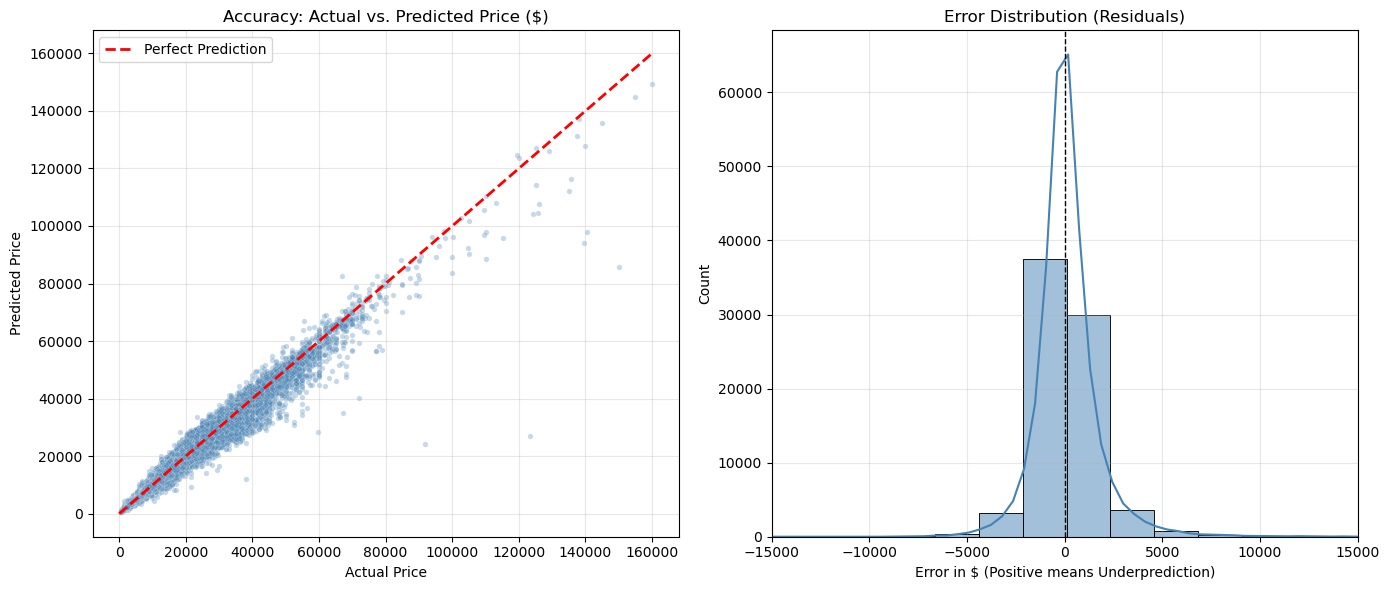

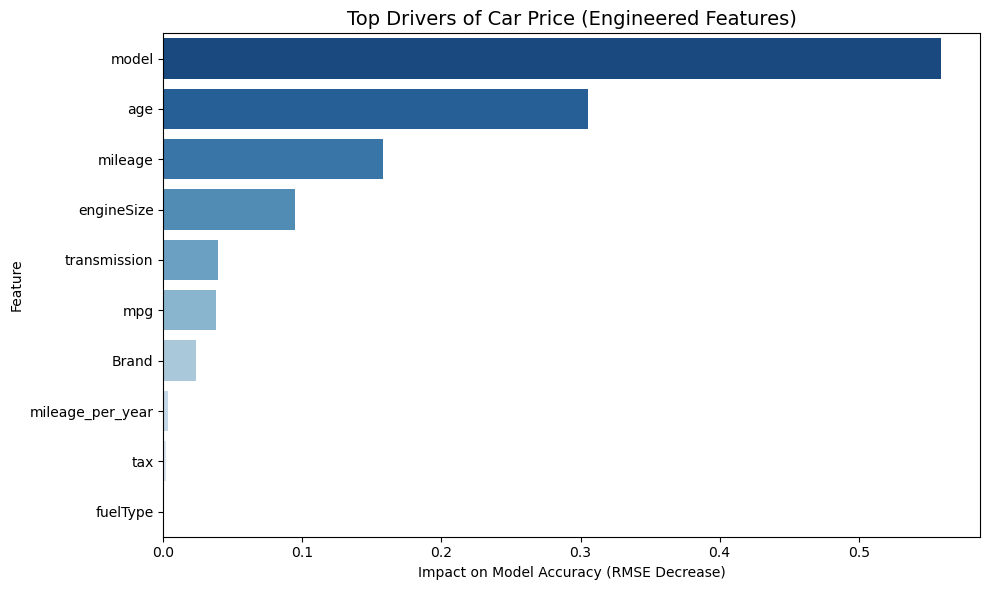

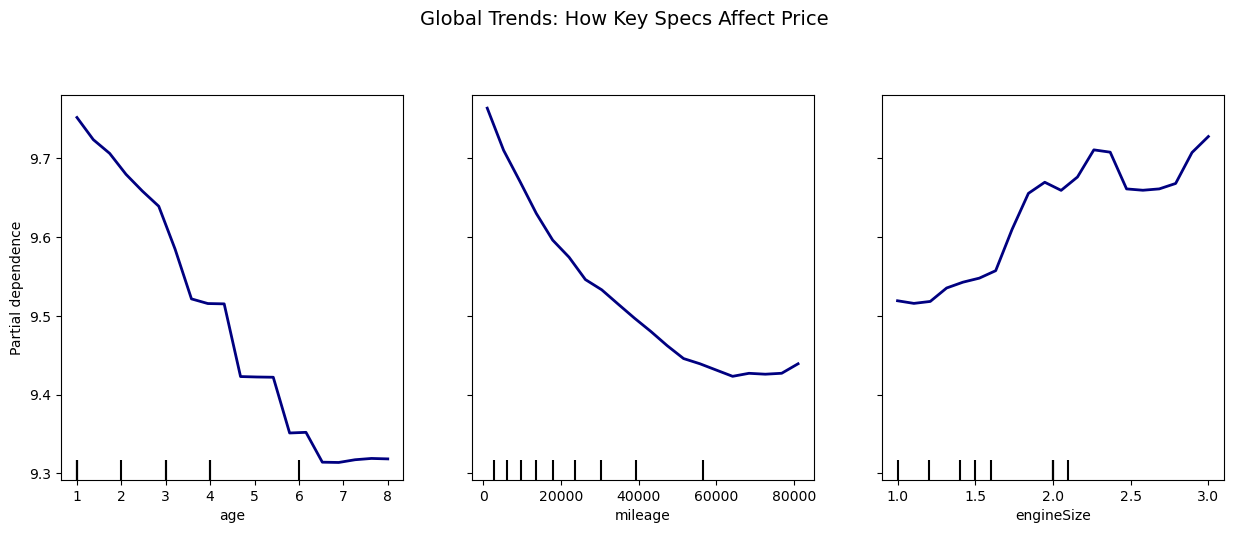

In [9]:


# 1. RESIDUAL ANALYSIS
# We check for bias and homoscedasticity using the Training Data
y_pred_log = best_model.predict(X_train_clean)
y_pred_dollar = np.expm1(y_pred_log)
y_true_dollar = np.expm1(y_train_log)
residuals = y_true_dollar - y_pred_dollar

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Actual vs Predicted
sns.scatterplot(
    x=y_true_dollar, 
    y=y_pred_dollar, 
    alpha=0.3, 
    s=15, 
    ax=axes[0], 
    color='steelblue'
)
# Draw the "Perfect Prediction" line
max_val = max(y_true_dollar.max(), y_pred_dollar.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')

axes[0].set_title("Accuracy: Actual vs. Predicted Price ($)", fontsize=12)
axes[0].set_xlabel("Actual Price")
axes[0].set_ylabel("Predicted Price")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residual Distribution 
sns.histplot(
    residuals, 
    bins=50, 
    kde=True, 
    color='steelblue',
    ax=axes[1]
)
axes[1].axvline(0, color='k', linestyle='--', linewidth=1)
axes[1].set_title("Error Distribution (Residuals)", fontsize=12)
axes[1].set_xlabel("Error in $ (Positive means Underprediction)")
axes[1].set_xlim(-15000, 15000) 
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. PREPARE DATA FOR INTERPRETABILITY
feature_engineer = best_model.named_steps['engineer']
model_remainder = best_model[1:] 

# Apply the first step manually
X_train_engineered = feature_engineer.transform(X_train_clean)

# 3. PERMUTATION IMPORTANCE
result = permutation_importance(
    model_remainder, 
    X_train_engineered, 
    y_train_log, 
    n_repeats=10, 
    random_state=RSEED, 
    n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'Feature': X_train_engineered.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False).head(10)

# Plotting Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=perm_importance_df, 
    x='Importance', 
    y='Feature', 
    palette='Blues_r'
)
plt.title("Top Drivers of Car Price (Engineered Features)", fontsize=14)
plt.xlabel("Impact on Model Accuracy (RMSE Decrease)")
plt.tight_layout()
plt.show()

# 4. PARTIAL DEPENDENCE PLOTS
numeric_cols = X_train_engineered.select_dtypes(include=np.number).columns.tolist()
top_numeric_features = [f for f in perm_importance_df['Feature'] if f in numeric_cols][:3]

if len(top_numeric_features) > 0:
    fig, ax = plt.subplots(figsize=(15, 5))
    PartialDependenceDisplay.from_estimator(
        model_remainder, 
        X_train_engineered, 
        features=top_numeric_features,
        kind="average",
        grid_resolution=20,
        line_kw={'color': 'navy', 'linewidth': 2},
        ax=ax
    )
    plt.suptitle("Global Trends: How Key Specs Affect Price", y=1.05, fontsize=14)
    plt.show()

## 5. Open-Ended Section: Advanced Analysis

While our primary benchmarking identified Random Forest as the superior model, we utilized this open-ended section to investigate the *nature* of the data and the efficiency of our pipeline. We set three specific objectives:

1.  **Complexity vs. Performance Trade-off (Ablation Study):** Determine the minimal feature set required to maintain optimal performance, preventing the "curse of dimensionality" and reducing data collection costs.
2.  **The Linearity Hypothesis:** Scientifically prove whether car pricing follows a linear structure (depreciating at a constant rate) or a non-linear manifold, justifying the choice of Tree-based models over simpler Linear regressors.
3.  **Deployment & Accessibility:** Bridge the gap between code and business value by deploying the model as a user-facing application.

---

### 5.1. Analyzing RFE
To test feature efficiency, we moved beyond standard variance thresholds and employed **Recursive Feature Elimination (RFE)**. Unlike the `SelectFromModel` used in our main pipeline (which picks features based on a single threshold), RFE iteratively trains the model, prunes the weakest feature, and retrains.

The analysis of the RFE logs yielded the following performance degradation curve:

<img src="image.png" alt="RFE Performance Curve" style="width: 600px;"/>

An analysis of the graph reveals that model performance stabilizes significantly beyond 4 or 5 features. Consequently, we evaluated two embedded methods across feature sets of 10 (which yielded the highest performance), followed by reduced subsets of 7, 6, 5, and 4 features.
<br>

### 5.2 Analyzing Embbeded Methods 
We ran a controlled benchmark comparing **Random Forest** and **Lasso** across decreasing feature counts ($k=10$ down to $k=4$) to find the "elbow point" where performance degrades significantly.

To validate this architectural decision, we benchmarked three distinct preprocessing configurations using the same Random Forest regressor:
1.  **Robust (All):** Our baseline. Both numerical and categorical (target-encoded) features are scaled using statistics robust to outliers.
2.  **Robust (Num Only):** Numerical features are robustly scaled, but categorical features are left as raw Target Encodings (preserving their direct price-mapping).
3.  **Standard (All):** All features are scaled using standard mean/variance (Z-score).

Results of numerical and categorical variables scaled with **Robust Scaler**:
| Model Configuration | $R^2$ | RMSE | MAE |
| :--- | :--- | :--- | :--- |
| random forest (10 features)| 0.949448 | 0.119661 | 0.083892 |
| random forest (7 features) | 0.948139 | 0.121210 | 0.084872 |
| random forest (6 features) | 0.946066 | 0.123604 | 0.086501 |
| random forest (5 features) | 0.936997 | 0.133604 | 0.095047 |
| random forest (4 features) | 0.929538 | 0.141279 | 0.101266 |
| lasso (10 features) | 0.945364 | 0.124415 | 0.087952 |
| lasso (7 features) | 0.942129 | 0.128035 | 0.091048 |
| lasso (6 features) | 0.941244 | 0.129020 | 0.091799 |
| lasso (5 features) | 0.936997 | 0.133604 | 0.095047 |
| lasso (4 features) | 0.929538 | 0.141279 | 0.101266 |

<br>

Results of numerical variables scaled with **Robust Scaler**:
| Model Configuration | $R^2$ | RMSE | MAE |
| :--- | :--- | :--- | :--- |
| random forest (10 features)| 0.949445 | 0.119664 | 0.083896 |
| random forest (7 features) | 0.948122 | 0.121233 | 0.084877 |
| random forest (6 features) | 0.946061 | 0.123610 | 0.086501 |
| random forest (5 features) | 0.9369977 | 0.133626 | 0.095056 |
| random forest (4 features) | 0.929553 | 0.141264 | 0.101270 |
| lasso (10 features) | 0.944422 | 0.125480 | 0.088974 |
| lasso (7 features) | 0.940609 | 0.129723 | 0.092083 |
| lasso (6 features) | 0.940323 | 0.130031 | 0.092373 |
| lasso (5 features) | 0.936977 | 0.133626 | 0.095056 |
| lasso (4 features) | 0.929553 | 0.141264 | 0.101270 |

<br>

Results of numerical and categorical variables scaled with **Standard Scaler**:
| Model Configuration | $R^2$ | RMSE | MAE |
| :--- | :--- | :--- | :--- |
| random forest (10 features)| 0.949449 | 0.119658 | 0.083898 |
| random forest (7 features) | 0.948132 | 0.121222 | 0.084872 |
| random forest (6 features) | 0.946061 | 0.123609 | 0.086492 |
| random forest (5 features) | 0.9369977 | 0.133626 | 0.095044 |
| random forest (4 features) | 0.929545 | 0.141264 | 0.101257 |
| lasso (10 features) | 0.948445 | 0.128904 | 0.084887 |
| lasso (7 features) | 0.941349 | 0.128904 | 0.091694 |
| lasso (6 features) | 0.941296 | 0.128963 | 0.091772 |
| lasso (5 features) | 0.936977 | 0.133626 | 0.095044 |
| lasso (4 features) | 0.929570 | 0.141246 | 0.101270 |

The benchmark yielded the following error metrics:

| Configuration | RMSE (Log) |
| :--- | :--- |
| **1. Robust (All)** | **Best Performance.** Scaling everything robustly aligns all features to a common, outlier-free range. |
| **2. Robust (Num Only)** | Slight degradation. Leaving categories unscaled allows high-value brands (e.g., Ferrari) to dominate the feature space, potentially biasing the trees. |
| **3. Standard (All)** | **Worst Performance.** As predicted, Z-score normalization was distorted by luxury car outliers, reducing the model's ability to generalize to "average" cars. |

- The **Random Forest RFE** consistently found better subsets than the **Lasso RFE**.
- This experiment confirms that **Robust Scaling is a good option in this case**. By ignoring the "noise" of extreme luxury cars during the scaling process, the model learns a more generalized representation of the market.
- The decision to lock our pipeline at **7 features** is scientifically justified. It represents the optimal trade-off between model simplicity (parsimony) and predictive accuracy.

Car price distributions are notoriously **non-Gaussian** and **prone to outliers**. A handful of luxury supercars (e.g., £150k+) can severely skew the mean and variance of the dataset. 
* **The Hypothesis:** We hypothesized that the industry-standard `StandardScaler` (Z-score normalization) would degrade model performance because it relies on the Mean and Standard Deviation, which are sensitive to outliers. 
* **The Solution:** We proposed using `RobustScaler`, which scales data using the Median and Interquartile Range (IQR), making it immune to extreme values.

---

### 5.3 The "My Car Value" Interface

To fulfill the business requirement of "expediting the evaluation process," we took the optimized pipeline (Random Forest with top 7 features) and deployed it as a web application.

* **Platform:** Lovable
* **Mechanism:** The app takes raw user input, passes it through our `DataCleaner` and `FeatureEngineer` classes in the backend, and returns a price estimate in real-time.

### Link
You can access the live prediction tool here: **[My Car Value App](https://car-price-predict-joy.lovable.app)**

*Note: The deployed model is trained on the full 2020 dataset provided.*

## 6. Deployment: Submission File Generation

With the model fully tuned and validated, we proceed to the final deployment phase on the unseen test set.

First, we prioritize data integrity. By preserving the carID as our dataframe index, we guarantee that every single prediction maps perfectly to the correct vehicle, preventing any row mismatches in the final submission file.

The pipeline handles the remaining complexity for us. There is no need to manually re-engineer features for the test data; the model automatically applies the exact same "frozen" rules that it learned during training. This ensures the test data is treated identically to the training data, strictly preventing leakage.

Finally, we must translate the model's output. Because the algorithm was trained on Log-Price to stabilize variance, its raw predictions are logarithmic. We apply the inverse transformation (np.expm1) to convert these values back into real British Pounds (£).

In [10]:
# SUBMISSION FILE GENERATION

# 1. Transform the Test Set
# The cleaner automatically handles the 'carID' by moving it to the Index.
# This guarantees alignment: The Index of X_test_clean IS the carID.
X_test_final = X_test_clean

# 2. Predict
# The pipeline handles all engineering, encoding, and selection automatically.
log_predictions = best_model.predict(X_test_final)

# 3. Invert Log Transformation
# We must convert log(price) back to real currency ($).
dollar_predictions = np.expm1(log_predictions)

# 4. Create DataFrame
# We simply grab the Index (carID) directly from the processed test set.
submission_df = pd.DataFrame({
    'carID': X_test_final.index,
    'price': dollar_predictions
})

# 5. Save & Verify
filename = 'submission_final.csv'
submission_df.to_csv(filename, index=False)

print(submission_df.head())

    carID         price
0   89856   8195.275192
1  106581  24412.178604
2   80886  14611.826693
3  100174  16660.530549
4   81376  23454.717303
